In [1]:
import nest_asyncio
nest_asyncio.apply()

from agents import Agent, Runner

In [2]:
g_sheets_agent = Agent(name="Google-Sheets-Agent", instructions="You help with Google Sheets information.")

In [3]:
bash_cmds_agent = Agent(name="Bash-Commands-Agent", instructions="You help with information about Bash commands. Your output is always a bash cmd and a simple justification.")

In [4]:
from agents import InputGuardrail, GuardrailFunctionOutput, Agent, Runner
from pydantic import BaseModel

class GoogleSheetsOrBashOutput(BaseModel):
    is_google_sheets_or_bash: bool
    reasoning: str

guardrail_agent = Agent(
    name="Guardrail check",
    instructions="Check if the user is asking about google sheets stuff or bash commands.",
    output_type=GoogleSheetsOrBashOutput,
)

async def gsheets_or_bash_guardrail(ctx, agent, input_data):
    result = await Runner.run(guardrail_agent, input_data, context=ctx.context)
    final_output = result.final_output_as(GoogleSheetsOrBashOutput)
    return GuardrailFunctionOutput(
        output_info=final_output,
        tripwire_triggered=not final_output.is_google_sheets_or_bash,
    )

In [5]:
triage_agent = Agent(
    name="Triage Agent",
    instructions="You determine which agent to use based on the user's homework question",
    handoffs=[g_sheets_agent, bash_cmds_agent],
    input_guardrails=[
        InputGuardrail(guardrail_function=gsheets_or_bash_guardrail),
    ]
)

In [6]:
from agents import Runner

async def main():
    result = await Runner.run(triage_agent, "What is the right command to list the files in the current directory?")
    print(result.final_output)
    
    result = await Runner.run(triage_agent, "In google sheets, how do I sort data from one column according to the values in another column?")
    print(result.final_output)

In [7]:
import asyncio

asyncio.run(main())

```bash
ls
```

It lists files and directories in the current directory.
To sort data in one column based on the values in another column in Google Sheets, follow these steps:

1. **Select the Data Range:**
   - Click and drag to select the range of data you want to sort, including both columns.

2. **Open Sort Options:**
   - Go to the menu and click on **Data**.

3. **Sort Range:**
   - Choose **Sort range** from the dropdown menu.

4. **Select Sort Criteria:**
   - A dialog box will appear. Check the option "Data has header row" if your columns have headers.
   - Select the column by which you want to sort from the drop-down menu. This should be the column with values determining the order.
   - Choose the sort order: **A-Z** or **Z-A** for ascending or descending order respectively.

5. **Apply the Sort:**
   - Click on **Sort**.

Your data should now be sorted according to the values in the selected column.


**View your traces**

To review what happened during your agent run, navigate to the [Trace viewer](https://platform.openai.com/traces) in the OpenAI Dashboard to view traces of your agent runs.

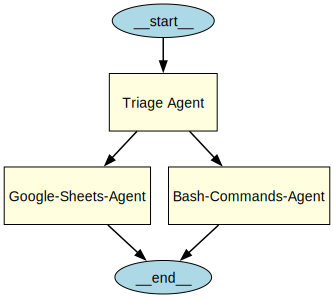

In [ ]:
from agents.extensions.visualization import draw_graph

draw_graph(triage_agent)

In [ ]:
from agents import Agent, FunctionTool, RunContextWrapper, function_tool
from pydantic import BaseModel, Field
import matplotlib.pyplot as plt
import json

class PlotData(BaseModel):
    x_values: list[float] = Field(description="The x-values to plot")
    y_values: list[float] = Field(description="The y-values to plot")
    title: str = Field(description="The title of the graph")
    x_label: str = Field(description="The label of the x-axis")
    y_label: str = Field(description="The label of the y-axis")
    plot_color: str = Field(description="The color of the plot")

@function_tool
def plot_data(data: PlotData):
    """Plot data on a graph"""
    plt.plot(data.x_values, data.y_values, color=data.plot_color)
    plt.title(data.title)
    plt.xlabel(data.x_label)
    plt.ylabel(data.y_label)
    plt.show()
    return "Graph plotted successfully"




agent = Agent(name="Test Agent", instructions="You are a helpful assistant with the ability to plot data in graphs.",
              tools=[plot_data],
              )
for tool in agent.tools:
    if isinstance(tool, FunctionTool):
        print(tool.name)
        print(tool.description)
        print(json.dumps(tool.params_json_schema, indent=2))
        print()

plot_data
Plot data on a graph
{
  "$defs": {
    "PlotData": {
      "properties": {
        "x_values": {
          "description": "The x-values to plot",
          "items": {
            "type": "number"
          },
          "title": "X Values",
          "type": "array"
        },
        "y_values": {
          "description": "The y-values to plot",
          "items": {
            "type": "number"
          },
          "title": "Y Values",
          "type": "array"
        },
        "title": {
          "description": "The title of the graph",
          "title": "Title",
          "type": "string"
        },
        "x_label": {
          "description": "The label of the x-axis",
          "title": "X Label",
          "type": "string"
        },
        "y_label": {
          "description": "The label of the y-axis",
          "title": "Y Label",
          "type": "string"
        },
        "plot_color": {
          "description": "The color of the plot",
          "title":

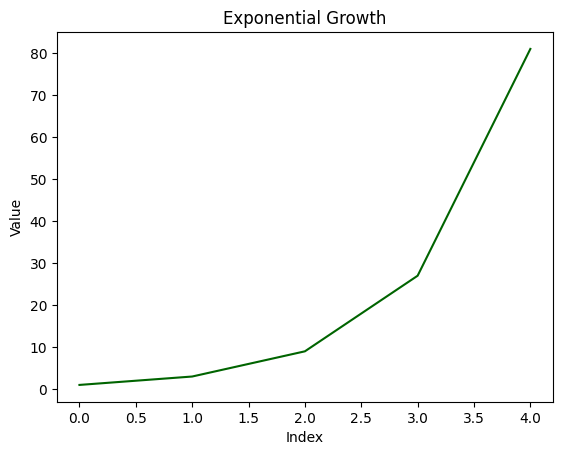

The graph of the data has been plotted with a dark green line. The title is "Exponential Growth" with "Index" as the x-axis label and "Value" as the y-axis label.


In [ ]:
task = "Plot this data for me: [1, 3, 9, 27, 81] make it dark green with a nice title and labels"

result = Runner.run_sync(agent, task)
print(result.final_output)